#Import libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import Adam
from keras.callbacks import History
from keras import callbacks

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/data/NASA_Turbofan_Jet")

Mounted at /content/drive


In [ ]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index

    return df_train, df_test, y_true

In [ ]:
df_train, df_test, y_true = prepare_data()
df_train.shape, df_test.shape, y_true.shape

((20631, 19), (13096, 18), (100, 2))

In [ ]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [ ]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [ ]:
df_train['failure'] = [1 if i < 75 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 75 else 0 for i in y_true.RUL]

In [ ]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,1.0,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,1.0,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,1.0,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,1.0,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,1.0,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0


In [ ]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,1.0,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,1.0,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,1.0,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,1.0,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,1.0,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [ ]:
y_true.head()

,RUL,UnitNumber,failure
0,112,0,0
1,98,1,0
2,69,2,1
3,82,3,0
4,91,4,0


In [ ]:

def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

In [ ]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [ ]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value

    id_df = df_mask.append(id_df,ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    start = num_elements-seq_length
    stop = num_elements

    lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

In [ ]:
sequence_length = 50 #predicting using last 30 cycle values
mask_value = 0

In [ ]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 16)


In [ ]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "failure")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [ ]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

<ipython-input-14-67bfa53ae23e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)


(100, 50, 16)


In [ ]:
#true target of test
y_test = y_true.RUL.values
y_test.shape

(100,)

In [ ]:
nb_features = x_train.shape[2]
nb_out = 1

In [ ]:
nb_features


16

In [ ]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1

cls_wt = {0: class_1/total, 1: class_0/total}

In [ ]:
cls_wt

{0: 0.4767656220202149, 1: 0.5232343779797851}

In [ ]:
pd.Series(y_train).value_counts()[0]

8231

In [ ]:
pd.Series(y_train).value_counts()[1]

7500

#results function

In [ ]:
def print_results(y_test, y_pred):

    #f1-score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_true.failure, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, y_pred)
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(y_test, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    threshold = np.round(thresholds[ix],3)

    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    plt.show()

#Model1 (1 hidden layer)

In [ ]:
history = History()

model1 = Sequential()
model1.add(LSTM(
         units=4,
         return_sequences=False,
         input_shape=(sequence_length, nb_features)))
model1.add(Dense(units=1, activation='sigmoid'))
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 336       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 341 (1.33 KB)
Trainable params: 341 (1.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
# fit the model
model1.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history])

Epoch 1/5
222/222 [==============================] - 15s 19ms/step - loss: 0.2553 - accuracy: 0.7847 - val_loss: 0.4003 - val_accuracy: 0.8424
Epoch 2/5
222/222 [==============================] - 2s 7ms/step - loss: 0.1959 - accuracy: 0.8266 - val_loss: 0.3639 - val_accuracy: 0.8482
Epoch 3/5
222/222 [==============================] - 2s 9ms/step - loss: 0.1785 - accuracy: 0.8416 - val_loss: 0.3462 - val_accuracy: 0.8577
Epoch 4/5
222/222 [==============================] - 2s 9ms/step - loss: 0.1680 - accuracy: 0.8548 - val_loss: 0.3298 - val_accuracy: 0.8717
Epoch 5/5
222/222 [==============================] - 2s 10ms/step - loss: 0.1619 - accuracy: 0.8623 - val_loss: 0.3285 - val_accuracy: 0.8596
CPU times: user 13.1 s, sys: 1.13 s, total: 14.2 s
Wall time: 25.2 s


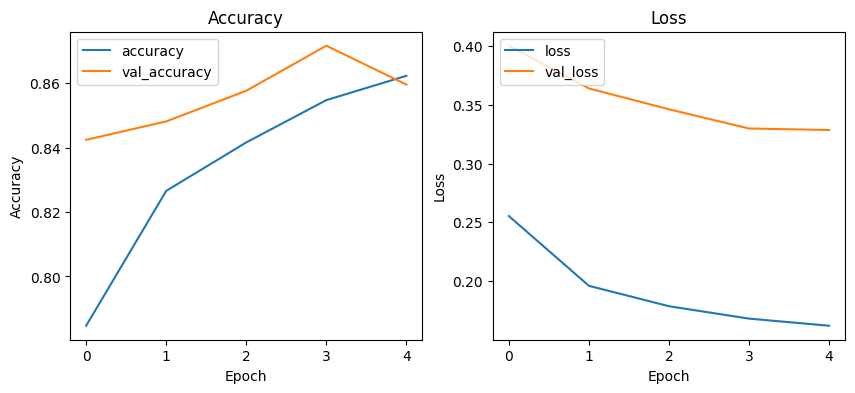

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['accuracy', 'val_accuracy'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['loss', 'val_loss'], loc='upper left')
ax[1].set_title('Loss')
plt.show()

4/4 [==============================] - 1s 5ms/step
F1 Score:  0.8809523809523809
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        57
           1       0.90      0.86      0.88        43

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

Area under curve :  0.8951448388412893 



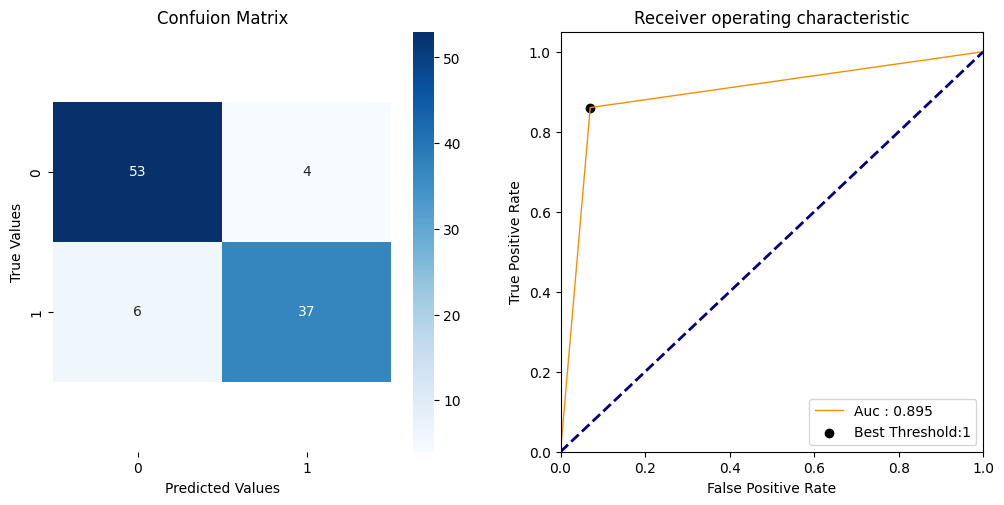

In [ ]:
y_pred_probs = model1.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
print_results(y_true.failure, y_pred)

#Model2 (early stopping)

In [ ]:
history = History()

model2 = Sequential()
model2.add(LSTM(
         units=4,
         return_sequences=False,
         input_shape=(sequence_length, nb_features)))
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 341 (1.33 KB)
Trainable params: 341 (1.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
# fit the model
model2.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/5
222/222 [==============================] - 8s 9ms/step - loss: 0.2568 - accuracy: 0.7969 - val_loss: 0.4192 - val_accuracy: 0.8488
Epoch 2/5
222/222 [==============================] - 1s 6ms/step - loss: 0.1986 - accuracy: 0.8332 - val_loss: 0.3491 - val_accuracy: 0.8488
Epoch 3/5
222/222 [==============================] - 2s 9ms/step - loss: 0.1606 - accuracy: 0.8765 - val_loss: 0.2765 - val_accuracy: 0.8863
Epoch 4/5
222/222 [==============================] - 3s 11ms/step - loss: 0.1394 - accuracy: 0.8924 - val_loss: 0.2605 - val_accuracy: 0.9028
Epoch 5/5
222/222 [==============================] - 2s 8ms/step - loss: 0.1258 - accuracy: 0.9015 - val_loss: 0.2344 - val_accuracy: 0.9149
CPU times: user 11.8 s, sys: 487 ms, total: 12.3 s
Wall time: 15.9 s


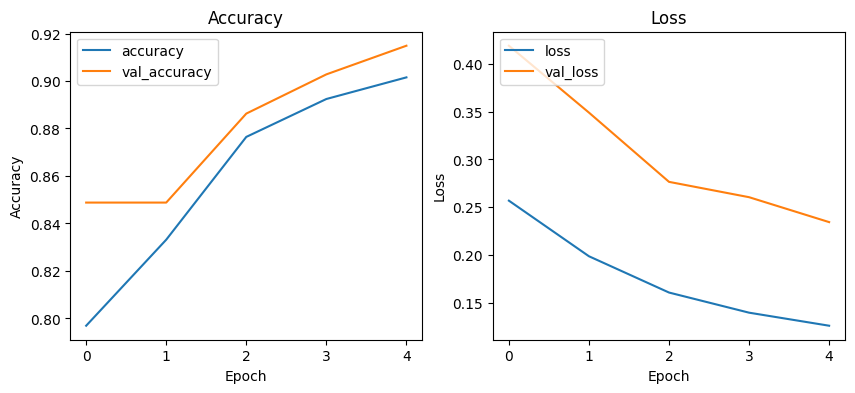

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['accuracy', 'val_accuracy'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['loss', 'val_loss'], loc='upper left')
ax[1].set_title('Loss')
plt.show()

4/4 [==============================] - 1s 5ms/step
F1 Score:  0.8941176470588236
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        57
           1       0.90      0.88      0.89        43

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

Area under curve :  0.9067727458180335 



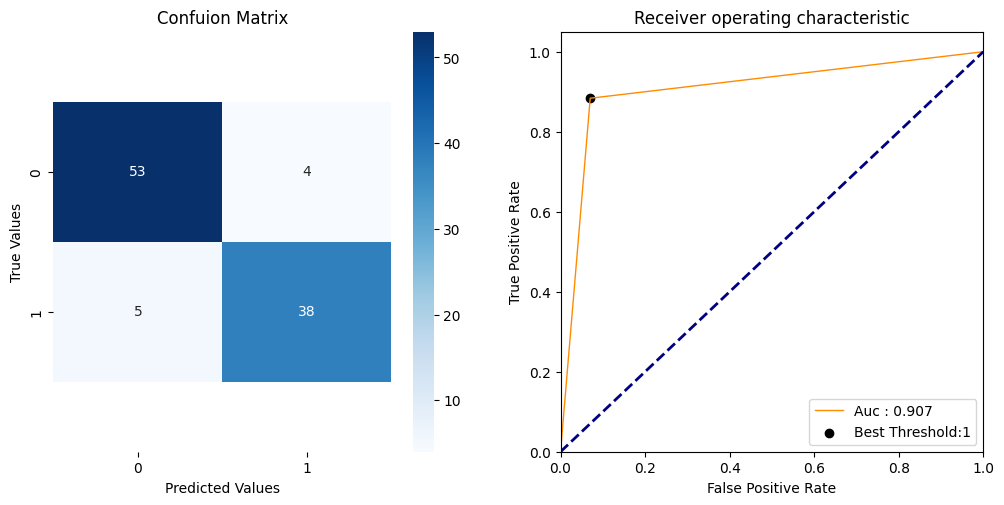

In [ ]:
y_pred_probs = model2.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
print_results(y_true.failure, y_pred)

#Model3 (dropout layer)

In [ ]:
history = History()

model3 = Sequential()
model3.add(LSTM(
         units=4,
         return_sequences=False,
         input_shape=(sequence_length, nb_features)))
model3.add(Dropout(0.25))
model3.add(Dense(units=1, activation='sigmoid'))
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4)                 336       
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 341 (1.33 KB)
Trainable params: 341 (1.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
# fit the model
model3.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
222/222 [==============================] - 4s 10ms/step - loss: 0.2335 - accuracy: 0.8008 - val_loss: 0.3537 - val_accuracy: 0.8710
Epoch 2/100
222/222 [==============================] - 2s 8ms/step - loss: 0.1820 - accuracy: 0.8515 - val_loss: 0.3300 - val_accuracy: 0.8621
Epoch 3/100
222/222 [==============================] - 2s 11ms/step - loss: 0.1692 - accuracy: 0.8630 - val_loss: 0.3035 - val_accuracy: 0.8748
Epoch 4/100
222/222 [==============================] - 2s 9ms/step - loss: 0.1578 - accuracy: 0.8748 - val_loss: 0.2805 - val_accuracy: 0.8812
Epoch 5/100
222/222 [==============================] - 2s 7ms/step - loss: 0.1492 - accuracy: 0.8805 - val_loss: 0.2572 - val_accuracy: 0.8939
Epoch 6/100
222/222 [==============================] - 1s 5ms/step - loss: 0.1426 - accuracy: 0.8854 - val_loss: 0.2483 - val_accuracy: 0.8971
Epoch 7/100
222/222 [==============================] - 1s 6ms/step - loss: 0.1343 - accuracy: 0.8951 - val_loss: 0.2474 - val_accuracy: 0.89

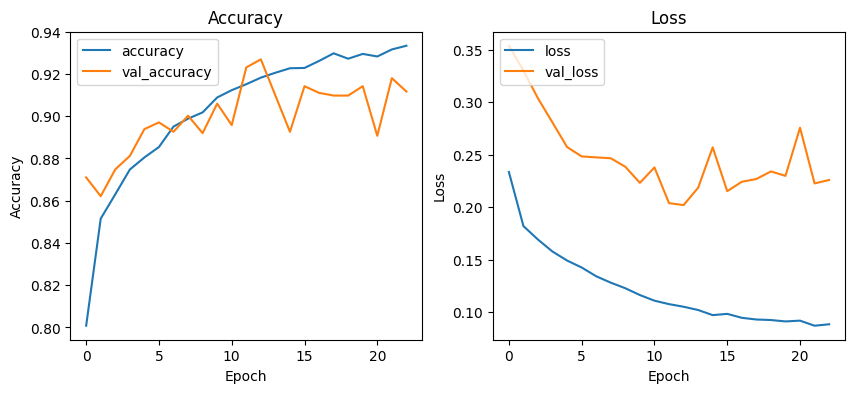

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['accuracy', 'val_accuracy'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['loss', 'val_loss'], loc='upper left')
ax[1].set_title('Loss')
plt.show()

4/4 [==============================] - 1s 5ms/step
F1 Score:  0.9195402298850575
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        57
           1       0.91      0.93      0.92        43

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Area under curve :  0.9300285597715218 



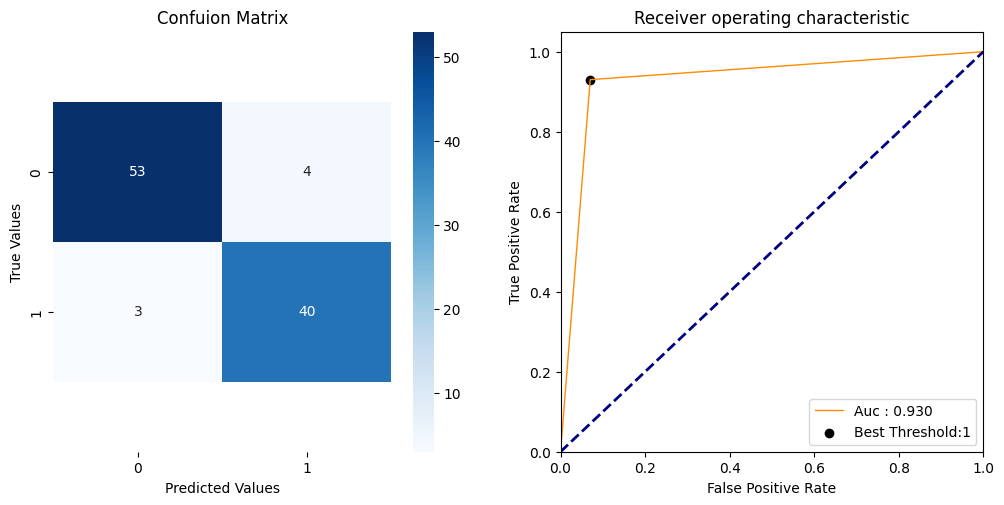

In [ ]:
y_pred_probs = model3.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
print_results(y_true.failure, y_pred)

#Model4 (2 hidden layers)

In [ ]:
history = History()

model4 = Sequential()
model4.add(LSTM(
         units=8,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model4.add(Dropout(0.2))
model4.add(LSTM(
         units=4,
         return_sequences=False))
model4.add(Dropout(0.2))
model4.add(Dense(units=1, activation='sigmoid'))
model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 8)             800       
                                                                 
 dropout_1 (Dropout)         (None, 50, 8)             0         
                                                                 
 lstm_4 (LSTM)               (None, 4)                 208       
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1013 (3.96 KB)
Trainable params: 1013 (3.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
# fit the model
model4.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])


Epoch 1/100
222/222 [==============================] - 6s 11ms/step - loss: 0.2187 - accuracy: 0.8248 - val_loss: 0.3141 - val_accuracy: 0.8710
Epoch 2/100
222/222 [==============================] - 2s 8ms/step - loss: 0.1593 - accuracy: 0.8800 - val_loss: 0.2630 - val_accuracy: 0.8914
Epoch 3/100
222/222 [==============================] - 2s 11ms/step - loss: 0.1390 - accuracy: 0.8964 - val_loss: 0.2346 - val_accuracy: 0.9060
Epoch 4/100
222/222 [==============================] - 2s 10ms/step - loss: 0.1266 - accuracy: 0.9038 - val_loss: 0.2492 - val_accuracy: 0.8939
Epoch 5/100
222/222 [==============================] - 3s 13ms/step - loss: 0.1167 - accuracy: 0.9099 - val_loss: 0.2548 - val_accuracy: 0.8945
Epoch 6/100
222/222 [==============================] - 3s 13ms/step - loss: 0.1131 - accuracy: 0.9140 - val_loss: 0.2556 - val_accuracy: 0.9136
Epoch 7/100
222/222 [==============================] - 3s 11ms/step - loss: 0.1095 - accuracy: 0.9152 - val_loss: 0.2368 - val_accuracy: 

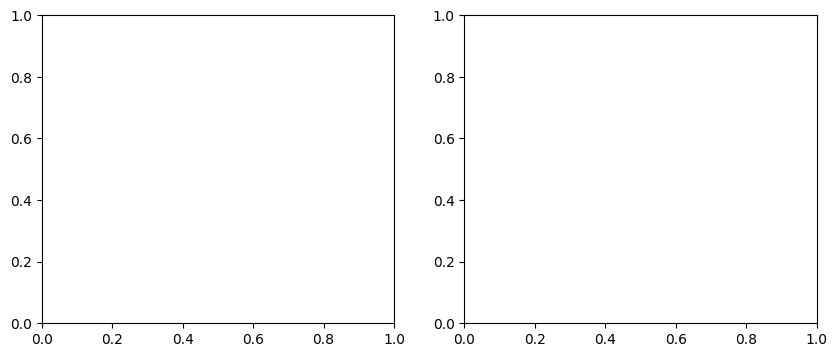

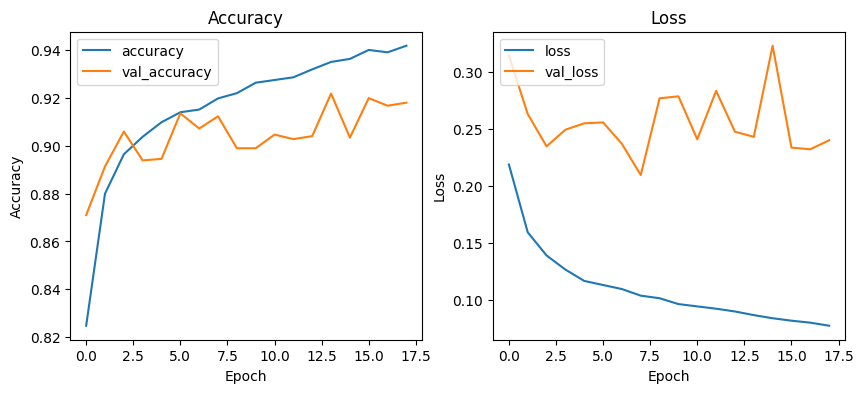

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['accuracy', 'val_accuracy'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['loss', 'val_loss'], loc='upper left')
ax[1].set_title('Loss')
plt.show()

4/4 [==============================] - 1s 6ms/step
F1 Score:  0.8809523809523809
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        57
           1       0.90      0.86      0.88        43

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

Area under curve :  0.8951448388412893 



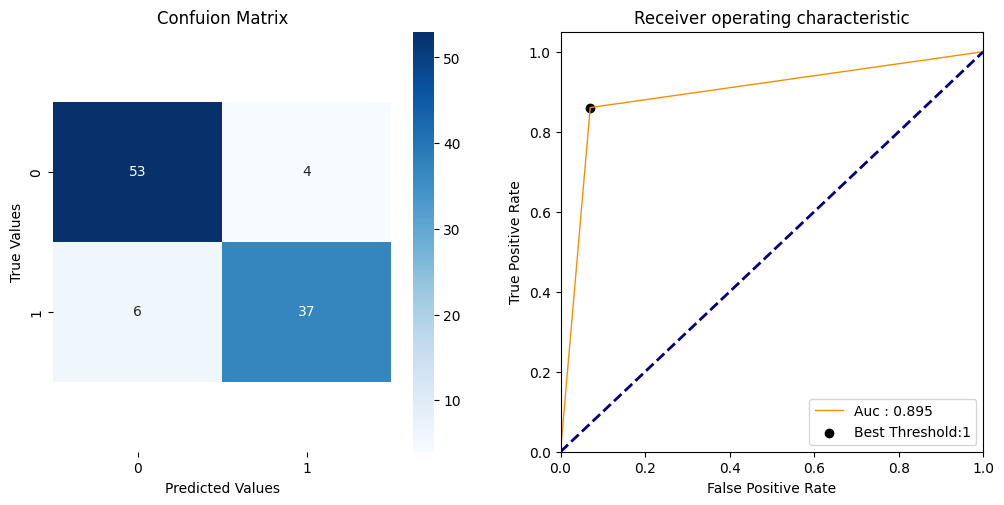

In [ ]:
y_pred_probs = model4.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
print_results(y_true.failure, y_pred)